# Imports required

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16, 14)

%matplotlib inline

# Custom Dataset using torch

In [2]:
class IrisDataset(Dataset):
    def __init__(self, root: str):
        dataframe = pd.read_csv(root)
        self.classes = dataframe.iloc[:, -1].unique().tolist()
        self.idx_to_class = dict(enumerate(self.classes))
        self.class_to_idx = {class_: idx for idx, class_ in self.idx_to_class.items()}

        self.data = dataframe.iloc[:, 1:-1].values.astype('uint8')
        self.labels = dataframe.replace({'Species': self.class_to_idx})['Species'].values
        self.labels = np.array(self.labels, dtype='int')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx].tolist(), dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

In [3]:
dataframe = pd.read_csv('./Data/Iris.csv')
dataframe.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


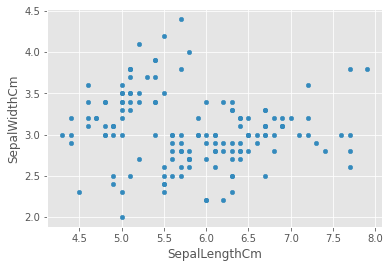

In [4]:
dataframe.plot(kind="scatter", x="SepalLengthCm", y="SepalWidthCm")
plt.show()

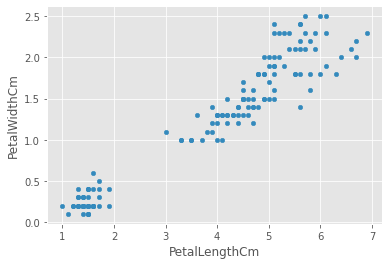

In [5]:
dataframe.plot(kind="scatter", x="PetalLengthCm", y="PetalWidthCm")
plt.show()

# Neural Network using Torch

In [6]:
class Block(nn.Module):
    def __init__(self, in_features: int, out_features: int, use_norm: bool = True, use_act: bool = True):
        super(Block, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, out_features, bias=not use_norm),

            nn.BatchNorm1d(out_features) if use_norm
            else nn.Identity(),

            nn.ReLU(inplace=True) if use_act
            else nn.Identity()
        )

    def forward(self, x):
        return self.block(x)


class NeuralNetwork(nn.Module):
    def __init__(self, in_features: int, n_classes: int, hidden_dim: int = 16, dropout: float = 0.5):
        super().__init__()
        self.network = nn.Sequential(
            Block(in_features, hidden_dim),
            nn.Dropout(dropout),
            Block(hidden_dim, hidden_dim * 2),
            nn.Dropout(dropout),
            Block(hidden_dim * 2, hidden_dim * 4),
            Block(hidden_dim * 4, n_classes, use_norm=False, use_act=False)
        )

    def forward(self, x):
        return self.network(x)

# Utility functions that help with the training of the network

In [7]:
def multiclass_accuracy(predictions: torch.Tensor, labels: torch.Tensor):
    pred_labels = torch.argmax(predictions, dim=1)
    return (pred_labels == labels).float().mean()

def train_fn(network: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, device: str = 'cpu'):
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    avg_loss = 0.0
    avg_acc = 0.0

    for batch_idx, (samples, targets) in loop:
        samples = samples.to(device)
        targets = targets.to(device)
        
        predictions = network(samples)
        loss = criterion(predictions, targets)
        accuracy = multiclass_accuracy(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_acc += accuracy.item()
        avg_loss += loss.item()

        loop.set_description(f'Step: [{batch_idx+1}/{len(dataloader)}]')
        loop.set_postfix(loss=avg_loss / (batch_idx+1), accuracy=avg_acc / (batch_idx + 1))

    return avg_loss, avg_acc


def eval_network(network: nn.Module, dataloader: DataLoader, criterion: nn.Module, device: str = 'cpu'):
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    avg_loss = 0.0
    avg_acc = 0.0
    
    network.eval()
    preds = []
    
    with torch.no_grad():
        for batch_idx, (samples, targets) in loop:
            samples = samples.to(device)
            targets = targets.to(device)

            predictions = network(samples)
            preds.append(torch.argmax(predictions, dim=1))
            loss = criterion(predictions, targets)
            accuracy = multiclass_accuracy(predictions, targets)

            avg_acc += accuracy.item()
            avg_loss += loss.item()

            loop.set_description(f'Step: [{batch_idx+1}/{len(dataloader)}]')
            loop.set_postfix(loss=avg_loss / (batch_idx+1), accuracy=avg_acc / (batch_idx + 1))
    
    return avg_loss, avg_acc, preds


def save_network(filename: str, network: nn.Module, optimizer: optim.Optimizer, **kwargs):
    checkpoint = {'network': network.state_dict(), 'optimizer': optimizer.state_dict()}
    for param in kwargs:
        checkpoint[param] = kwargs[param]
    print(f'-> Saving Model at {filename}')
    torch.save(checkpoint, filename)


def load_network(filename: str, network: nn.Module, optimizer: optim.Optimizer, lr: float, **kwargs):
    checkpoint = torch.load(filename)
    network.load_state_dict(checkpoint['network'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    meta_data = {}
    for param in kwargs:
        if checkpoint.get(param, None) is not None:
            meta_data[param] = checkpoint[param]

    return meta_data

# Hyperparameters and network configuration

In [8]:
n_epochs = 15
bs = 32
hidden_size = 32
input_size = 4
n_classes = 3
lr = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = NeuralNetwork(input_size, n_classes, hidden_size).to(device)
optimizer = optim.Adam(network.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Datasplit and Dataloading

In [9]:
dataset = IrisDataset(root='./Data/Iris.csv')

val_split = 0.1
lengths = list(map(int, [len(dataset) * (1-val_split), len(dataset) * val_split]))

train_ds, valid_ds = random_split(dataset, lengths)
train_dl, valid_dl = DataLoader(train_ds, batch_size=bs, shuffle=True), DataLoader(valid_ds, batch_size=2*bs, shuffle=True)

# Training Loop

In [10]:
print(f'Running on device: {device}')
for epoch in range(n_epochs):
    loss, accuracy = train_fn(network, train_dl, optimizer, criterion)
    if epoch % 2 == 0:
        save_network('./NeuralNetwork.pth.tar', network, optimizer, loss=loss, epoch=epoch, accuracy=accuracy)

Step: [2/5]:   0%|          | 0/5 [00:00<?, ?it/s, accuracy=0.5, loss=1.06] 

Running on device: cpu
-> Saving Model at ./NeuralNetwork.pth.tar
-> Saving Model at ./NeuralNetwork.pth.tar


Step: [1/5]:   0%|          | 0/5 [00:00<?, ?it/s, accuracy=0.562, loss=0.972]

-> Saving Model at ./NeuralNetwork.pth.tar
-> Saving Model at ./NeuralNetwork.pth.tar
-> Saving Model at ./NeuralNetwork.pth.tar


Step: [5/5]: 100%|██████████| 5/5 [00:00<00:00, 83.53it/s, accuracy=0.653, loss=0.91]

-> Saving Model at ./NeuralNetwork.pth.tar
-> Saving Model at ./NeuralNetwork.pth.tar
-> Saving Model at ./NeuralNetwork.pth.tar


# Evaluating the network on the Validation data

In [11]:
# Evaluating the network
val_loss, val_accuracy, preds = eval_network(network, valid_dl, criterion)
print(f'On the validation set\nLoss: {val_loss} Accuracy: {val_accuracy}')

Step: [1/1]: 100%|██████████| 1/1 [00:00<00:00, 179.38it/s, accuracy=0.867, loss=0.931]

On the validation set
Loss: 0.9305001497268677 Accuracy: 0.8666666746139526
